In [1]:
# requirements
import os
import cv2
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import filedialog, ttk
from PIL import Image, ImageTk
#import fitz  
import csv
import io

In [2]:
# 


In [3]:
# === Base Page Class ===
class Page(tk.Frame):
    def __init__(self, parent, **kwargs):
        super().__init__(parent, **kwargs)

# === Individual Pages ===
class HomePage(Page):
    def __init__(self, parent, **kwargs):
        super().__init__(parent, **kwargs)
        label = ttk.Label(self, text="Welcome to the OCT Deformation Tracking Suite", font=("Helvetica", 18))
        label.pack(pady=20)

In [4]:

class PreprocessingPage(Page):
    def __init__(self, parent, **kwargs):
        super().__init__(parent, **kwargs)

        # --- Controls Bar ---
        ctrl = ttk.Frame(self)
        ctrl.pack(fill='x', pady=10)
        ttk.Button(ctrl, text="Select Input Folder", command=self.load_images)\
            .pack(side='left', padx=5)
        ttk.Button(ctrl, text="Previous", command=self.prev_image)\
            .pack(side='left', padx=5)
        ttk.Button(ctrl, text="Next", command=self.next_image)\
            .pack(side='left', padx=5)
        ttk.Button(ctrl, text="Reorder…", command=self.open_reorder_dialog)\
            .pack(side='left', padx=5)

        # --- Canvas for display ---
        self.canvas = tk.Canvas(self, bg='#f0f0f0')
        self.canvas.pack(fill='both', expand=True, padx=10, pady=10)

        # --- Internal State ---
        self.entries = []            # list of (name, np.ndarray) in extraction order
        self.images = []             # just the image arrays
        self.reference_img = None
        self.index = 0
        self.preprocessed_steps = [] # list of dicts per image
        self.tk_imgs = {}            # cache of PhotoImage for canvas

    def preprocess_single_image(self, img, reference_img=None):
        steps = {'Original': img.copy()}
        steps['Denoised'] = cv2.medianBlur(img, 3)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        steps['Contrast Enhanced'] = clahe.apply(steps['Denoised'])
        if reference_img is not None:
            M = np.eye(2,3, dtype=np.float32)
            try:
                _, M = cv2.findTransformECC(reference_img, steps['Contrast Enhanced'], M,
                                            cv2.MOTION_EUCLIDEAN)
                steps['Motion Corrected'] = cv2.warpAffine(
                    steps['Contrast Enhanced'], M,
                    (img.shape[1], img.shape[0]),
                    flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP
                )
            except cv2.error:
                steps['Motion Corrected'] = steps['Contrast Enhanced'].copy()
        else:
            steps['Motion Corrected'] = steps['Contrast Enhanced'].copy()
        return steps

    def load_images(self):
        src_folder = filedialog.askdirectory(title="Select Input Folder")
        if not src_folder:
            return

        out_folder = os.path.join(src_folder, "extracted_OCT")
        os.makedirs(out_folder, exist_ok=True)

        # clear old
        import glob
        for old in glob.glob(os.path.join(out_folder, "*.png")):
            os.remove(old)

        self.entries = []
        seq_idx = 0   # visitation counter

        for fname in os.listdir(src_folder):
            if "OCT" not in fname.upper():
                continue
            path = os.path.join(src_folder, fname)
            ext  = os.path.splitext(fname)[1].upper()

            if ext == ".PDF":
                doc = fitz.open(path)
                for pnum, page in enumerate(doc):
                    for img_idx, img_info in enumerate(page.get_images(full=True)):
                        if img_idx != 1:
                            continue
                        xref     = img_info[0]
                        img_dict = doc.extract_image(xref)
                        pil_img  = Image.open(io.BytesIO(img_dict["image"])).convert("L")
                        arr      = np.array(pil_img)

                        # name with sequence index
                        base_name = f"{seq_idx:03d}_{os.path.splitext(fname)[0]}_p{pnum+1}_i{img_idx}.png"
                        pil_img.save(os.path.join(out_folder, base_name), "PNG")
                        self.entries.append((base_name, arr))
                        seq_idx += 1
                doc.close()

            elif ext in (".PNG", ".JPG", ".JPEG", ".TIF", ".TIFF"):
                img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue
                pil_img  = Image.fromarray(img)
                base_name = f"{seq_idx:03d}_{os.path.splitext(fname)[0]}.png"
                pil_img.save(os.path.join(out_folder, base_name), "PNG")
                self.entries.append((base_name, img))
                seq_idx += 1

        if not self.entries:
            messagebox.showwarning("No OCT Images",
                                   "No files with 'OCT' found in the selected folder.")
            return

        # now rebuild images/preprocessing
        self._rebuild_images_and_steps()
        self.index = 0
        self.show_current_image()


    def _rebuild_images_and_steps(self):
        # Called after load or after reorder
        self.images = [arr for (name, arr) in self.entries]
        self.reference_img = self.images[0]
        self.preprocessed_steps = [
            self.preprocess_single_image(img, self.reference_img)
            for img in self.images
        ]

    def show_current_image(self):
        self.canvas.delete("all")
        if not self.preprocessed_steps:
            return
        steps = self.preprocessed_steps[self.index]
        for i, (title, img) in enumerate(steps.items()):
            thumb  = Image.fromarray(img).resize((220,220))
            tk_img = ImageTk.PhotoImage(thumb)
            self.tk_imgs[i] = tk_img
            x = 10 + i*240
            self.canvas.create_image(x,10,anchor='nw',image=tk_img)
            self.canvas.create_text(x+110,240,text=title,font=("Helvetica",12))

    def next_image(self):
        if self.index < len(self.images)-1:
            self.index += 1
            self.show_current_image()

    def prev_image(self):
        if self.index>0:
            self.index -= 1
            self.show_current_image()

    def open_reorder_dialog(self):
        """Open a small dialog to let the user drag images up/down in self.entries."""
        dlg = tk.Toplevel(self)
        dlg.title("Reorder OCT Frames")
        dlg.grab_set()

        lb = tk.Listbox(dlg, height= min(10, len(self.entries)), width=40)
        lb.pack(side='left', fill='y', padx=(10,0), pady=10)
        for name, _ in self.entries:
            lb.insert('end', name)

        btn_frame = ttk.Frame(dlg)
        btn_frame.pack(side='left', fill='y', padx=10, pady=10)

        def move(up):
            idx = lb.curselection()
            if not idx:
                return
            i = idx[0]
            j = i-1 if up else i+1
            if j<0 or j>=lb.size():
                return
            # swap in Listbox
            name_i = lb.get(i)
            name_j = lb.get(j)
            lb.delete(i); lb.insert(i, name_j)
            lb.delete(j); lb.insert(j, name_i)
            lb.selection_clear(0,'end'); lb.selection_set(j)

        ttk.Button(btn_frame, text="↑ Move Up",   command=lambda: move(True)).pack(fill='x', pady=5)
        ttk.Button(btn_frame, text="↓ Move Down", command=lambda: move(False)).pack(fill='x', pady=5)
        ttk.Separator(btn_frame, orient='horizontal').pack(fill='x', pady=5)
        def apply_and_close():
            # reorder self.entries to match Listbox
            new_order = [lb.get(i) for i in range(lb.size())]
            name_to_entry = {name: arr for name, arr in self.entries}
            self.entries = [(n, name_to_entry[n]) for n in new_order]
            self._rebuild_images_and_steps()
            self.index = 0
            self.show_current_image()
            dlg.destroy()

        ttk.Button(btn_frame, text="Apply", command=apply_and_close).pack(fill='x', pady=(20,5))
        ttk.Button(btn_frame, text="Cancel", command=dlg.destroy).pack(fill='x')


In [5]:
import os
import re
import cv2
import numpy as np
import tkinter as tk
from tkinter import ttk, filedialog, messagebox
from PIL import Image, ImageTk

class OpticalFlowPage(ttk.Frame):
    def __init__(self, parent, **kwargs):
        super().__init__(parent, **kwargs)

        # Available algorithms
        self.algorithms = ['Farneback', 'Lucas-Kanade', 'Speckle Tracking', 'TVL1', 'DIS']

        try:
            self.tvl1 = cv2.optflow.DualTVL1OpticalFlow_create()
            self.tvl1.setTau(0.25)        # time step
            self.tvl1.setLambda(0.15)     # smoothness weight
            self.tvl1.setTheta(0.3)       # tightness of the solver
            self.tvl1.setScalesNumber(5)  # pyramid levels
            self.tvl1.setWarpingsNumber(3)
            self.tvl1.setEpsilon(0.01)    # convergence threshold
        except AttributeError:
            # opencv‑contrib not installed, drop TVL1
            self.algorithms.remove('TVL1')
            self.tvl1 = None

        # --- DIS init (so you don't recreate it every frame) ---
        self.dis = cv2.DISOpticalFlow_create(cv2.DISOPTICAL_FLOW_PRESET_MEDIUM)

        # Controls frame
        ctrl = ttk.Frame(self)
        ctrl.pack(fill='x', pady=10)
        ttk.Button(ctrl, text="Select Folder", command=self.load_images).pack(side='left', padx=5)
        ttk.Button(ctrl, text="Previous Image", command=self.prev_image).pack(side='left', padx=5)
        ttk.Button(ctrl, text="Next Image", command=self.next_image).pack(side='left', padx=5)

        ttk.Label(ctrl, text="Algorithm:").pack(side='left', padx=(20,5))
        self.selected_alg = tk.StringVar(value=self.algorithms[0])
        alg_combo = ttk.Combobox(ctrl, textvariable=self.selected_alg,
                                 values=self.algorithms, state='readonly', width=15)
        alg_combo.pack(side='left', padx=5)
        alg_combo.bind('<<ComboboxSelected>>', lambda e: self._compute_all_and_show())

        ttk.Label(ctrl, text="Grid Step:").pack(side='left', padx=(20,5))
        self.grid_step = tk.IntVar(value=20)
        ttk.Scale(ctrl, from_=1, to=50, variable=self.grid_step,
                  command=lambda e: self.show_flow()).pack(side='left', padx=5)
        self.step_label = ttk.Label(ctrl, text=str(self.grid_step.get()))
        self.step_label.pack(side='left')
        self.grid_step.trace_add("write", lambda *args: self.step_label.config(text=str(self.grid_step.get())))

        # Display options: computed trail/net and NPY-based
        self.show_trail_var = tk.BooleanVar(value=True)
        self.show_net_var   = tk.BooleanVar(value=False)
        self.show_npy_trail_var = tk.BooleanVar(value=False)
        self.show_npy_net_var   = tk.BooleanVar(value=False)
        self.show_net_error_var = tk.BooleanVar(value=False)
        ttk.Checkbutton(ctrl, text="Show Computed Trail", variable=self.show_trail_var,
                       command=self.show_flow).pack(side='left', padx=(20,5))
        ttk.Checkbutton(ctrl, text="Show Computed Net", variable=self.show_net_var,
                       command=self.show_flow).pack(side='left', padx=5)
        ttk.Checkbutton(ctrl, text="Show NPY Trail", variable=self.show_npy_trail_var,
                       command=self.show_flow).pack(side='left', padx=5)
        ttk.Checkbutton(ctrl, text="Show NPY Net", variable=self.show_npy_net_var,
                       command=self.show_flow).pack(side='left', padx=5)
        ttk.Checkbutton(ctrl, text="Show Net Error", variable=self.show_net_error_var,
                        command=self.show_flow).pack(side='left', padx=5)
        ttk.Button(ctrl, text="Export Deformation Field",
                   command=self.export_deformation_field)\
            .pack(side='left', padx=5)

        # Canvas for display
        self.canvas = tk.Canvas(self, bg='#f0f0f0')
        self.canvas.pack(fill='both', expand=True, padx=10, pady=10)
        self.canvas.bind('<Configure>', lambda e: self.show_flow())

        # Internal state
        self.images = []
        self.flows_inc = []      # computed incremental flows
        self.net_flow = None     # computed net flow
        self.npy_inc = []        # loaded incremental dx/dy as npy per frame
        self.npy_net = None      # loaded or computed net from npy
        self.index = 0
        self.current_folder = None

    @staticmethod
    def _numeric_key(fn):
        name = os.path.splitext(fn)[0]
        m = re.search(r"(\d+)", name)
        return (0, int(m.group(1))) if m else (1, name.lower())

    def load_images(self):
        folder = filedialog.askdirectory()
        if not folder:
            return
        self.current_folder = folder
        files = os.listdir(folder)
        imgs = sorted([f for f in files if f.lower().endswith(('.png','.jpg','.jpeg','.tif'))],
                      key=self._numeric_key)
        self.images = [cv2.imread(os.path.join(folder, f), cv2.IMREAD_GRAYSCALE)
                       for f in imgs]

        # Load .npy dx_/dy_ files for incremental displacement
        dx_files = sorted([f for f in files if f.startswith('dx_') and f.endswith('.npy')], key=self._numeric_key)
        dy_files = sorted([f for f in files if f.startswith('dy_') and f.endswith('.npy')], key=self._numeric_key)
        self.npy_inc = [None]
        for dx_fn, dy_fn in zip(dx_files, dy_files):
            dx = np.load(os.path.join(folder, dx_fn))
            dy = np.load(os.path.join(folder, dy_fn))
            self.npy_inc.append(np.dstack((dx, dy)))
        # NPY net will be derived dynamically from trail, not precomputed
        self.npy_net = None
        self.index = 0
        self._compute_all()
        self.show_flow()

    def prev_image(self):
        if self.index > 0:
            self.index -= 1
            self.show_flow()

    def next_image(self):
        if self.index < len(self.images) - 1:
            self.index += 1
            self.show_flow()

    def _compute_all(self):
        alg = self.selected_alg.get()
        # Computed incremental flows
        self.flows_inc = [None]
        for i in range(1, len(self.images)):
            f = self.compute_flow(self.images[i-1], self.images[i], alg)
            self.flows_inc.append(f)

    def _compute_all_and_show(self):
        if self.images:
            self._compute_all()
            self.show_flow()

    def compute_flow(self, img1, img2, method):
        if method == 'Farneback':
            return cv2.calcOpticalFlowFarneback(
                img1, img2, None,
                pyr_scale  = 0.7,
                levels     = 5,
                winsize    = 21,
                iterations = 1,
                poly_n     = 7,
                poly_sigma = 1.1,
                flags      = 0
            )
        if method == 'TVL1':
            if not self.tvl1:
                raise RuntimeError("TV-L1 not available – check opencv-contrib install")
            # pre-normalize
            im1 = img1.astype(np.float32) / 255.0
            im2 = img2.astype(np.float32) / 255.0

            # optional parameter overrides:
            for name in ['Tau','Lambda','Theta','ScalesNumber','WarpingsNumber','Epsilon']:
                if name.lower() in params:
                    getattr(self.tvl1, f"set{name}")(params[name.lower()])

            # warm‑start (or None)
            if params.get('use_init_flow', False):
                h, w = im1.shape
                init = np.zeros((h,w,2), np.float32)
            else:
                init = None

            return self.tvl1.calc(im1, im2, init)
        if method == 'Lucas-Kanade':
            # Dense LK: track every pixel
            h, w = img1.shape
            # build Nx1x2 grid of all (x,y)
            ys, xs = np.mgrid[0:h, 0:w]
            p0 = np.stack([xs, ys], axis=-1).astype(np.float32)
            p0 = p0.reshape(-1,1,2)  # (h*w)×1×2

            # run PyrLK (tweak winSize/maxLevel/criteria as you like)
            p1, st, _ = cv2.calcOpticalFlowPyrLK(
                img1, img2, p0, None,
                winSize  = (21,21),
                maxLevel = 3,
                criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)
            )

            # reshape results and build dense flow
            flow = np.zeros((h, w, 2), dtype=np.float32)
            valid = (st.reshape(-1) == 1)
            p0_valid = p0.reshape(-1,2)[valid]
            p1_valid = p1.reshape(-1,2)[valid]
            disp = p1_valid - p0_valid

            xs = p0_valid[:,0].astype(int)
            ys = p0_valid[:,1].astype(int)
            flow[ys, xs, 0] = disp[:,0]
            flow[ys, xs, 1] = disp[:,1]

            return flow
            return np.stack((pts0[:,0], pts0[:,1], disp[:,0], disp[:,1]), axis=1)
        if method == 'Speckle Tracking':
            h, w = img1.shape
            step = self.grid_step.get()
            pts = [(x,y) for y in range(0,h,step) for x in range(0,w,step)]
            pts1 = []
            half = 5
            tpl_h, tpl_w = 2*half+1, 2*half+1
            for x0,y0 in pts:
                tpl = img1[max(y0-half,0):y0+half+1, max(x0-half,0):x0+half+1]
                win = img2[max(y0-step,0):y0+step+1, max(x0-step,0):x0+step+1]
                if win.shape[0]<tpl_h or win.shape[1]<tpl_w:
                    pts1.append((x0,y0))
                    continue
                _,_,_,mx = cv2.minMaxLoc(cv2.matchTemplate(win, tpl, cv2.TM_CCOEFF_NORMED))
                dx = mx[0] - (win.shape[1]//2 - half)
                dy = mx[1] - (win.shape[0]//2 - half)
                pts1.append((x0+dx, y0+dy))
            disp = np.array(pts1) - np.array(pts)
            return np.concatenate((np.array(pts), disp), axis=1)
        if method == "DIS":
            self.dis = cv2.DISOpticalFlow_create(cv2.DISOPTICAL_FLOW_PRESET_MEDIUM)
            return self.dis.calc(img1, img2, None)
        return None
        

    def show_flow(self):
        self.canvas.delete('all')
        if not self.images:
            return

        # Fit raw image to canvas
        img = self.images[self.index]
        h_img, w_img = img.shape
        c_w, c_h = self.canvas.winfo_width(), self.canvas.winfo_height()
        scale = min(c_w/w_img, c_h/h_img)
        nw, nh = int(w_img*scale), int(h_img*scale)
        x_off, y_off = (c_w-nw)//2, (c_h-nh)//2
        rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        pil = Image.fromarray(rgb).resize((nw, nh))
        self.photo = ImageTk.PhotoImage(pil)
        self.canvas.create_image(x_off, y_off, anchor='nw', image=self.photo)

        step = self.grid_step.get()

        # Computed trail
        if self.show_trail_var.get() and self.index>0:
            color='blue'
            if hasattr(self.flows_inc[1], 'ndim') and self.flows_inc[1].ndim==3:
                for y0 in range(0,h_img,step):
                    for x0 in range(0,w_img,step):
                        x_prev, y_prev = float(x0), float(y0)
                        for t in range(1, self.index+1):
                            f = self.flows_inc[t]
                            yi = int(np.clip(round(y_prev),0,h_img-1))
                            xi = int(np.clip(round(x_prev),0,w_img-1))
                            dx, dy = f[yi, xi, 0], f[yi, xi, 1]
                            x_next, y_next = x_prev+dx, y_prev+dy
                            x1,y1 = x_prev*scale+x_off, y_prev*scale+y_off
                            x2,y2 = x_next*scale+x_off, y_next*scale+y_off
                            self.canvas.create_line(x1,y1,x2,y2, fill=color)
                            x_prev, y_prev = x_next, y_next
            else:
                for x0, y0, dx, dy in self.flows_inc[self.index].astype(float):
                    x_prev, y_prev = x0, y0
                    for t in range(1, self.index+1):
                        f = self.flows_inc[t]
                        mask = (f[:,0]==y_prev)&(f[:,1]==x_prev)
                        if not mask.any(): break
                        idx = np.where(mask)[0][0]
                        dx_t, dy_t = f[idx,2], f[idx,3]
                        x_next, y_next = x_prev+dx_t, y_prev+dy_t
                        x1,y1 = x_prev*scale+x_off, y_prev*scale+y_off
                        x2,y2 = x_next*scale+x_off, y_next*scale+y_off
                        self.canvas.create_line(x1,y1,x2,y2, fill=color)
                        x_prev, y_prev = x_next, y_next

        # Computed net head‑to‑tail from image0 to final image
        if self.show_net_var.get() and len(self.flows_inc) > 1:
            color = 'red'
            n_frames = len(self.flows_inc)  # total frames = images count

            for y0 in range(0, h_img, step):
                for x0 in range(0, w_img, step):
                    x_prev, y_prev = float(x0), float(y0)

                    # integrate every incremental flow from frame1 → final
                    for t in range(1, n_frames):
                        f = self.flows_inc[t]
                        if f is None:
                            break

                        if hasattr(f, 'ndim') and f.ndim == 3:
                            yi = int(np.clip(round(y_prev), 0, h_img-1))
                            xi = int(np.clip(round(x_prev), 0, w_img-1))
                            dx, dy = f[yi, xi, 0], f[yi, xi, 1]
                        else:
                            # sparse case (Lucas‑Kanade)
                            pts0 = f[:, :2]
                            disps = f[:, 2:]
                            # find nearest point
                            dists = np.hypot(pts0[:,0]-x_prev, pts0[:,1]-y_prev)
                            idx = np.argmin(dists)
                            dx, dy = disps[idx]

                        x_prev += dx
                        y_prev += dy

                    # draw one net arrow from (x0,y0) to final (x_prev,y_prev)
                    x1 = x0*scale + x_off
                    y1 = y0*scale + y_off
                    x2 = x_prev*scale + x_off
                    y2 = y_prev*scale + y_off
                    self.canvas.create_line(x1, y1, x2, y2, fill=color)

        # NPY-based trail
        if self.show_npy_trail_var.get() and self.npy_inc and self.index > 0:
            color = 'green'
            for y0 in range(0, h_img, step):
                for x0 in range(0, w_img, step):
                    x_prev, y_prev = float(x0), float(y0)
                    # walk through each incremental npy flow up to current frame
                    for t in range(1, self.index+1):
                        f = self.npy_inc[t]
                        if f is None:
                            break
                        yi = int(np.clip(round(y_prev), 0, h_img-1))
                        xi = int(np.clip(round(x_prev), 0, w_img-1))
                        # invert both x and y displacements
                        dx, dy = -f[yi, xi, 0], -f[yi, xi, 1]
                        x_next, y_next = x_prev + dx, y_prev + dy
                        x1 = x_prev*scale + x_off
                        y1 = y_prev*scale + y_off
                        x2 = x_next*scale + x_off
                        y2 = y_next*scale + y_off
                        self.canvas.create_line(x1, y1, x2, y2, fill=color)
                        x_prev, y_prev = x_next, y_next


        # NPY‑based net + net‑error metrics
        if (self.show_npy_net_var.get() or self.show_net_error_var.get()) and len(self.npy_inc) > 1:
            total_err = 0.0
            total_pct = 0.0
            count     = 0
            color     = 'lime'
            n_frames  = len(self.npy_inc)

            for y0 in range(0, h_img, step):
                for x0 in range(0, w_img, step):
                    # actual NPY net endpoint
                    xa, ya = float(x0), float(y0)
                    for t in range(1, n_frames-1):
                        f = self.npy_inc[t]
                        if f is None: break
                        yi = int(np.clip(round(ya), 0, h_img-1))
                        xi = int(np.clip(round(xa), 0, w_img-1))
                        dx, dy = -f[yi, xi, 0], -f[yi, xi, 1]
                        xa += dx; ya += dy

                    # computed net endpoint
                    xc, yc = float(x0), float(y0)
                    for t in range(1, len(self.flows_inc)):
                        f = self.flows_inc[t]
                        if f is None: break
                        if hasattr(f, 'ndim') and f.ndim == 3:
                            yi = int(np.clip(round(yc), 0, h_img-1))
                            xi = int(np.clip(round(xc), 0, w_img-1))
                            dx, dy = f[yi, xi, 0], f[yi, xi, 1]
                        else:
                            pts0, disp = f[:, :2], f[:, 2:]
                            dists = np.hypot(pts0[:,0]-xc, pts0[:,1]-yc)
                            idx = np.argmin(dists)
                            dx, dy = disp[idx]
                        xc += dx; yc += dy

                    # draw NPY net if requested
                    x1, y1 = x0*scale + x_off, y0*scale + y_off
                    x2, y2 = (x0+ (xa - x0))*scale + x_off, (y0+ (ya - y0))*scale + y_off
                    if self.show_npy_net_var.get():
                        self.canvas.create_line(x1, y1, x2, y2, fill=color)

                    # draw error line and accumulate metrics
                    if self.show_net_error_var.get():
                        # if the calculated position of the pixel after the full displacement is not on the image, its excluded from error calculations.
                        if xc > 360 or xc < 0 or yc > 360 or yc < 0:
                            continue
                        err = np.hypot(xc - xa, yc - ya)
                        total_err += err
                        mag = max(np.hypot(ya - y0, xa - x0), 1e-6)
                        total_pct += (err/mag)*100.0
                        count += 1
                        x3, y3 = xc*scale + x_off, yc*scale + y_off
                        self.canvas.create_line(x2, y2, x3, y3, fill='pink')

            # after looping over all grid points, display the summary
            if self.show_net_error_var.get() and count > 0:
                avg_err = total_err / count
                avg_pct = total_pct / count
                cum_err = total_err
                self.canvas.create_text(
                    10, 10, anchor='nw',
                    text=(f"Avg error: {avg_err:.2f}px\nCumulative error: {cum_err:.2f}px\n" 
                          f"Avg % error: {avg_pct:.1f}%\nSamples: {count}"),
                    fill='black', font=('TkDefaultFont', 10, 'bold')
                )
    
    def export_deformation_field(self):
        if not self.current_folder or not self.images:
            messagebox.showerror("Export Error", "No folder loaded")
            return

        # compute net flow over all frames (head-to-tail)
        H, W = self.images[0].shape
        net = np.zeros((H, W, 2), dtype=np.float32)

        # make sure flows_inc is up to date
        self._compute_all()

        for y0 in range(H):
            for x0 in range(W):
                xa, ya = float(x0), float(y0)
                for f in self.flows_inc[1:]:
                    if f is None: break
                    # sample at nearest integer
                    yi = int(np.clip(round(ya), 0, H-1))
                    xi = int(np.clip(round(xa), 0, W-1))
                    dx, dy = float(f[yi, xi, 0]), float(f[yi, xi, 1])
                    xa += dx; ya += dy
                net[y0, x0, 0] = xa - x0
                net[y0, x0, 1] = ya - y0

        # write out
        out_dir = os.path.join(self.current_folder, "deformation_field")
        os.makedirs(out_dir, exist_ok=True)
        np.save(os.path.join(out_dir, "deformation_dx.npy"), net[:,:,0])
        np.save(os.path.join(out_dir, "deformation_dy.npy"), net[:,:,1])

        messagebox.showinfo(
            "Export Complete",
            f"Saved deformation_dx.npy and deformation_dy.npy\nin:\n{out_dir}"
        )


In [6]:
class FeatureRegistrationPage(Page):
    def __init__(self, parent, **kwargs):
        super().__init__(parent, **kwargs)

        # --- Controls bar ---
        ctrl = ttk.Frame(self)
        ctrl.pack(fill='x', pady=10)

        ttk.Button(ctrl, text="Select Folder", command=self.load_images).pack(side='left', padx=5)
        ttk.Button(ctrl, text="Previous",      command=self.prev_image).pack(side='left', padx=5)
        ttk.Button(ctrl, text="Next",          command=self.next_image).pack(side='left', padx=5)

        # Relative threshold slider (background minus pixel)
        ttk.Label(ctrl, text="Rel Thresh:").pack(side='left', padx=(20,5))
        self.rel_thresh = tk.IntVar(value=15)
        rel_sld = ttk.Scale(ctrl, from_=0, to=100, variable=self.rel_thresh,
                            command=lambda e: self.show_registration())
        rel_sld.pack(side='left')
        self.rel_lbl = ttk.Label(ctrl, text=str(self.rel_thresh.get()))
        self.rel_lbl.pack(side='left', padx=(5,10))
        self.rel_thresh.trace_add("write",
            lambda *a: self.rel_lbl.config(text=str(self.rel_thresh.get()))
        )

        # Min contour area slider
        ttk.Label(ctrl, text="Min Area:").pack(side='left', padx=(10,5))
        self.min_area = tk.IntVar(value=50)
        area_sld = ttk.Scale(ctrl, from_=1, to=2000, variable=self.min_area,
                             command=lambda e: self.show_registration())
        area_sld.pack(side='left', padx=(0,5))
        self.area_lbl = ttk.Label(ctrl, text=str(self.min_area.get()))
        self.area_lbl.pack(side='left')
        self.min_area.trace_add("write",
            lambda *a: self.area_lbl.config(text=str(self.min_area.get()))
        )

        # --- Canvas ---
        self.canvas = tk.Canvas(self, bg='#f0f0f0')
        self.canvas.pack(fill='both', expand=True, padx=10, pady=10)

        # --- State ---
        self.images = []    # grayscale frames
        self.index  = 0
        self.tk_imgs = []   # PhotoImage refs

    def load_images(self):
        folder = filedialog.askdirectory()
        if not folder:
            return

        fnames = [f for f in os.listdir(folder) if f.lower().endswith('.png')]
        fnames.sort(key=lambda fn: int(os.path.splitext(fn)[0]) if fn[:-4].isdigit() else fn)
        self.images = [
            cv2.imread(os.path.join(folder, fn), cv2.IMREAD_GRAYSCALE)
            for fn in fnames
        ]
        if not self.images:
            return

        self.index = 0
        self.show_registration()

    def _segment_local_dark_spots(self, img):
        """
        Finds spots darker than their local background.
        Returns filtered contours.
        """
        # 1) compute local background by Gaussian blur
        #    kernel size = roughly 1/10th of min dimension, odd
        #k = max(5, (min(img.shape)//10)//2*2+1)
        k= 3
        bg = cv2.GaussianBlur(img, (k,k), 0)

        # 2) difference image: bg - img
        diff = cv2.subtract(bg, img)

        # 3) threshold difference
        thresh = self.rel_thresh.get()
        _, mask = cv2.threshold(diff, thresh, 255, cv2.THRESH_BINARY)

        # 4) clean mask
        kern = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kern, iterations=1)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kern, iterations=2)

        # 5) find contours
        cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # 6) filter by area
        h, w = img.shape
        min_a = self.min_area.get()
        max_a = 0.8 * h * w
        good = [c for c in cnts
                if min_a <= cv2.contourArea(c) <= max_a]
        return good

    def show_registration(self):
        self.canvas.delete("all")
        self.tk_imgs.clear()
        if not self.images:
            return

        img = self.images[self.index]

        # prepare three variants
        denoised = cv2.bilateralFilter(img, d=9, sigmaColor=75, sigmaSpace=75)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        enhanced = clahe.apply(denoised)
        variants = [('Raw', img), ('Denoised', denoised), ('Enhanced', enhanced)]

        # layout thumbnails
        self.canvas.update_idletasks()
        W = self.canvas.winfo_width()
        pad = 20
        thumb_w = (W - pad*4) // 3

        for i, (name, vimg) in enumerate(variants):
            vis = cv2.cvtColor(vimg, cv2.COLOR_GRAY2BGR)
            # detect local dark spots
            cnts = self._segment_local_dark_spots(vimg)
            # draw outlines in green
            cv2.drawContours(vis, cnts, -1, (0,255,0), 1)

            # resize to thumbnail
            h, w = vis.shape[:2]
            thumb_h = int(thumb_w * h / w)
            thumb = cv2.resize(vis, (thumb_w, thumb_h), interpolation=cv2.INTER_AREA)

            imgtk = ImageTk.PhotoImage(Image.fromarray(thumb))
            self.tk_imgs.append(imgtk)

            x = pad + i*(thumb_w + pad)
            y = pad
            self.canvas.create_image(x, y, anchor='nw', image=imgtk)
            self.canvas.create_text(
                x + thumb_w//2, y + thumb_h + 12,
                text=name, font=("Helvetica", 9, "bold"), fill="#333"
            )

        total = len(self.images)
        self.master.master.title(
            f"Local Dark Spots — Img{self.index}/{total-1}  "
            f"(Δ>{self.rel_thresh.get()}, Area>{self.min_area.get()})"
        )

    def next_image(self):
        if self.index < len(self.images)-1:
            self.index += 1
            self.show_registration()

    def prev_image(self):
        if self.index > 0:
            self.index -= 1
            self.show_registration()


In [7]:
import tkinter as tk
from tkinter import ttk
from PIL import Image, ImageTk
import numpy as np
import imageio
from scipy.ndimage import gaussian_filter, map_coordinates
import cv2

def generate_oct_like_image(h, w, struct_sigma=12, speckle_scale=0.2, speckle_contrast=5.0):
    base_struct = gaussian_filter(np.random.randn(h, w), sigma=struct_sigma)
    norm = (base_struct - base_struct.min()) / base_struct.ptp()
    tissue = norm * 255
    speckle = np.random.rayleigh(scale=speckle_scale, size=(h, w))
    speckle = (speckle - speckle.mean()) * speckle_contrast + speckle.mean()
    full_img = np.clip(tissue * (1+speckle), 0, 255)
    return full_img.astype(np.float32)

def generate_displacement_field(h, w, magnitude=10, smoothness=30):
    dx = gaussian_filter(np.random.randn(h, w), sigma=smoothness) * magnitude
    dy = gaussian_filter(np.random.randn(h, w), sigma=smoothness) * magnitude
    return dx, dy

def apply_displacement(img, dx, dy):
    h, w = img.shape
    Y, X = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')
    coords = [Y + dy, X + dx]
    warped = map_coordinates(img, coords, order=1, mode='reflect')
    return warped

class ImageSynthesisPage(ttk.Frame):
    def __init__(self, parent, **kwargs):
        super().__init__(parent, **kwargs)
        ctrl = ttk.Frame(self)
        ctrl.pack(fill='x', pady=10)

        ttk.Label(ctrl, text="Frames:").pack(side='left')
        self.num_frames = tk.IntVar(value=9)
        ttk.Spinbox(ctrl, from_=1, to=20, width=4, textvariable=self.num_frames).pack(side='left')

        ttk.Label(ctrl, text="Deform:").pack(side='left', padx=(10,0))
        self.deform_scale = tk.DoubleVar(value=300.0)
        ttk.Scale(ctrl, from_=0, to=400, variable=self.deform_scale, length=100).pack(side='left')
        ttk.Label(ctrl, textvariable=self.deform_scale, width=4).pack(side='left')

        ttk.Label(ctrl, text="Noise:").pack(side='left', padx=(10,0))
        self.noise_scale = tk.DoubleVar(value=0.12)
        ttk.Scale(ctrl, from_=0, to=0.4, variable=self.noise_scale, length=100).pack(side='left')
        ttk.Label(ctrl, textvariable=self.noise_scale, width=4).pack(side='left')

        ttk.Label(ctrl, text="Struct.:").pack(side='left', padx=(10,0))
        self.struct_sigma = tk.DoubleVar(value=10.0)
        ttk.Scale(ctrl, from_=1, to=20, variable=self.struct_sigma, length=100).pack(side='left')
        ttk.Label(ctrl, textvariable=self.struct_sigma, width=4).pack(side='left')

        ttk.Button(ctrl, text="Generate Sequence", command=self.generate_sequence).pack(side='left', padx=10)
        ttk.Button(ctrl, text="Export Sequence", command=self.export_sequence).pack(side='left')

        self.show_cumulative = tk.BooleanVar(value=False)
        self.show_incremental = tk.BooleanVar(value=False)
        ttk.Checkbutton(ctrl, text="Show Cumulative", variable=self.show_cumulative, command=self.refresh_current_frame).pack(side='left')
        ttk.Checkbutton(ctrl, text="Show Incremental", variable=self.show_incremental, command=self.refresh_current_frame).pack(side='left')

        nav = ttk.Frame(self)
        nav.pack(fill='x')
        ttk.Button(nav, text="⟨ Prev", command=self.show_prev).pack(side='left')
        ttk.Button(nav, text="Next ⟩", command=self.show_next).pack(side='right')
        self.frame_label = ttk.Label(nav, text="Frame 0/0")
        self.frame_label.pack(side='left', expand=True)

        self.canvas = tk.Canvas(self, bg='black', width=364, height=364)
        self.canvas.pack(fill='both', expand=True, padx=10, pady=10)
        self.tk_img = None

        self.original = None
        self.sequence = []
        self.curr_idx = 0
        self.dx_total = None
        self.dy_total = None
        self.per_frame_displacements = []

    def generate_sequence(self):
        h, w = 364, 364
        base = generate_oct_like_image(h, w, struct_sigma=self.struct_sigma.get(), speckle_scale=self.noise_scale.get())
        self.original = base.astype(np.uint8)
        self.sequence = [self.original]
        self.per_frame_displacements = []

        self.dx_total = np.zeros((h, w), dtype=np.float32)
        self.dy_total = np.zeros((h, w), dtype=np.float32)

        for _ in range(self.num_frames.get()):
            dx, dy = generate_displacement_field(h, w, magnitude=self.deform_scale.get(), smoothness=30)
            self.per_frame_displacements.append((dx, dy))
            self.dx_total += dx
            self.dy_total += dy
            warped = apply_displacement(base, self.dx_total, self.dy_total)
            self.sequence.append(np.clip(warped, 0, 255).astype(np.uint8))

        self.curr_idx = 0
        self.show_frame(0)

    def show_frame(self, idx):
        arr = self.sequence[idx].copy()
        if self.show_incremental.get() and idx > 0:
            dx, dy = self.per_frame_displacements[idx - 1]
            arr = self.overlay_displacement_arrows(arr, dx, dy, color=(0, 0, 255))
        if self.show_cumulative.get():
            arr = self.overlay_displacement_arrows(arr, self.dx_total, self.dy_total, color=(0, 0, 200))
        self.display_array(arr)
        self.frame_label.config(text=f"Frame {idx+1}/{len(self.sequence)}")

    def refresh_current_frame(self):
        self.show_frame(self.curr_idx)

    def show_prev(self):
        if not self.sequence:
            return
        self.curr_idx = max(0, self.curr_idx - 1)
        self.show_frame(self.curr_idx)

    def show_next(self):
        if not self.sequence:
            return
        self.curr_idx = min(len(self.sequence)-1, self.curr_idx + 1)
        self.show_frame(self.curr_idx)

    def display_array(self, arr):
        pil = Image.fromarray(arr.astype(np.uint8))
        self.tk_img = ImageTk.PhotoImage(pil)
        self.canvas.config(width=arr.shape[1], height=arr.shape[0])
        self.canvas.delete('all')
        self.canvas.update_idletasks()
        canvas_w = self.canvas.winfo_width()
        canvas_h = self.canvas.winfo_height()
        img_w, img_h = self.tk_img.width(), self.tk_img.height()
        x = (canvas_w - img_w) // 2
        y = (canvas_h - img_h) // 2
        self.canvas.create_image(x, y, anchor='nw', image=self.tk_img)

    def overlay_displacement_arrows(self, img, dx, dy, step=20, color=(0, 0, 255)):
        vis = cv2.cvtColor(img.copy(), cv2.COLOR_GRAY2BGR)
        h, w = img.shape
        for y in range(0, h, step):
            for x in range(0, w, step):
                pt1 = (x, y)
                pt2 = (int(x + dx[y, x]), int(y + dy[y, x]))
                cv2.arrowedLine(vis, pt1, pt2, color, 1, tipLength=0.3)
        return cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)

    def export_sequence(self):
        if not self.sequence:
            return

        folder = filedialog.askdirectory(title="Select Export Folder")
        if not folder:
            return

        # Export images
        for i, img in enumerate(self.sequence):
            img_path = os.path.join(folder, f"frame_{i:03d}.png")
            imageio.imwrite(img_path, img.astype(np.uint8))

        # Export incremental deformation fields (from frame i to i+1)
        for i, (dx, dy) in enumerate(self.per_frame_displacements):
            np.save(os.path.join(folder, f"dx_{i:03d}_{i+1:03d}.npy"), dx)
            np.save(os.path.join(folder, f"dy_{i:03d}_{i+1:03d}.npy"), dy)

        # Optional: export cumulative deformation fields
        np.save(os.path.join(folder, f"dx_cumulative.npy"), self.dx_total)
        np.save(os.path.join(folder, f"dy_cumulative.npy"), self.dy_total)

        print(f"Exported {len(self.sequence)} frames and {len(self.per_frame_displacements)} deformation fields to {folder}")


In [8]:
import os
import glob
import tkinter as tk
from tkinter import ttk, filedialog
import itertools
import numpy as np
import cv2
from scipy.ndimage import map_coordinates

class BenchmarkingPage(ttk.Frame):
    def __init__(self, parent, **kwargs):
        super().__init__(parent, **kwargs)

        # Controls frame
        ctrl = ttk.Frame(self)
        ctrl.pack(fill='x', pady=10)

        # Dataset selector
        ttk.Button(ctrl, text="Select Dataset Folder", command=self.load_dataset_root).pack(side='left', padx=5)
        self.dataset_label = ttk.Label(ctrl, text="No folder selected")
        self.dataset_label.pack(side='left', padx=5)

        # Algorithm selector (only Farneback for grid search)
        ttk.Label(ctrl, text="Algorithm:").pack(side='left', padx=(20,5))
        self.algorithms = ['Farneback']
        self.selected_alg = tk.StringVar(value='Farneback')
        alg_combo = ttk.Combobox(ctrl, textvariable=self.selected_alg,
                                 values=self.algorithms, state='readonly', width=12)
        alg_combo.pack(side='left')

        # Farneback parameter entries (comma-separated lists)
        param_defs = [
            ("pyr_scale", "0.3,0.5,0.7"),
            ("levels",    "1,2,3,4"),
            ("winsize",   "9,15,21"),
            ("iterations","1,3,5"),
            ("poly_n",    "5,7"),
            ("poly_sigma","1.1,1.5,1.9"),
        ]
        self.param_vars = {}
        for label, default in param_defs:
            var = tk.StringVar(value=default)
            self.param_vars[label] = var
            ttk.Label(ctrl, text=f"{label}:").pack(side='left', padx=(10,0))
            ttk.Entry(ctrl, textvariable=var, width=8).pack(side='left')

        # Run button
        ttk.Button(ctrl, text="Run Grid Search", command=self.run_benchmark).pack(side='left', padx=10)
        self.status = ttk.Label(ctrl, text="Idle")
        self.status.pack(side='left', padx=5)

        # Results table
        cols = ("params", "avgEPE", "avgWarpErr")
        self.table = ttk.Treeview(self, columns=cols, show="headings")
        for c in cols:
            self.table.heading(c, text=c)
            self.table.column(c, width=120)
        self.table.pack(fill='both', expand=True, padx=10, pady=10)

    def load_dataset_root(self):
        folder = filedialog.askdirectory(title="Select Synthetic OCT Dataset Folder")
        if not folder:
            return
        self.dataset_root = folder
        self.dataset_label.config(text=os.path.basename(folder))
        self.status.config(text="Dataset loaded")

    def run_benchmark(self):
        # Ensure dataset selected
        if not hasattr(self, 'dataset_root'):
            self.status.config(text="Select dataset folder first")
            return

        # Parse parameter lists
        lists = {}
        for name, var in self.param_vars.items():
            vals = [float(x) if '.' in x else int(x) for x in var.get().split(',')]
            lists[name] = vals

        # Generate all combinations
        combos = list(itertools.product(
            lists['pyr_scale'], lists['levels'], lists['winsize'],
            lists['iterations'], lists['poly_n'], lists['poly_sigma']
        ))

        # Clear previous results
        for i in self.table.get_children():
            self.table.delete(i)

        # Dataset subsets
        sets = sorted(d for d in os.listdir(self.dataset_root)
                      if os.path.isdir(os.path.join(self.dataset_root, d)))
        total = len(combos)
        count = 0

        # Grid search loop
        for combo in combos:
            ps, lv, ws, iters, pn, psig = combo
            epe_accum, werr_accum = [], []

            for subset in sets:
                path = os.path.join(self.dataset_root, subset)
                frames = sorted(glob.glob(os.path.join(path, "frame_*.png")))
                imgs = [cv2.imread(f, cv2.IMREAD_GRAYSCALE) for f in frames]
                epe_vals, werr_vals = [], []

                for i in range(len(imgs)-1):
                    img1, img2 = imgs[i], imgs[i+1]
                    dx_gt = np.load(os.path.join(path, f"dx_{i:03d}_{i+1:03d}.npy"))
                    dy_gt = np.load(os.path.join(path, f"dy_{i:03d}_{i+1:03d}.npy"))

                    flow = cv2.calcOpticalFlowFarneback(
                        img1, img2, None,
                        pyr_scale=ps, levels=int(lv),
                        winsize=int(ws), iterations=int(iters),
                        poly_n=int(pn), poly_sigma=psig,
                        flags=0
                    )
                    dx_pred, dy_pred = flow[...,0], flow[...,1]
                    epe_vals.append(np.sqrt((dx_gt-dx_pred)**2 + (dy_gt-dy_pred)**2).mean())
                    warped = self.warp_image(img1.astype(np.float32), dx_pred, dy_pred)
                    werr_vals.append(((warped - img2.astype(np.float32))**2).mean())

                if epe_vals:
                    epe_accum.append(np.mean(epe_vals))
                    werr_accum.append(np.mean(werr_vals))

            # Compute and insert average metrics
            avg_epe = float(np.mean(epe_accum)) if epe_accum else np.nan
            avg_werr = float(np.mean(werr_accum)) if werr_accum else np.nan
            param_str = f"ps={ps},lv={lv},ws={ws},it={iters},pn={pn},psig={psig}"
            self.table.insert("", "end", values=(param_str, f"{avg_epe:.4f}", f"{avg_werr:.4f}"))

            count += 1
            self.status.config(text=f"Test {count}/{total}")
            self.update_idletasks()

        self.status.config(text="Grid search complete")

    def warp_image(self, img, dx, dy):
        h, w = img.shape
        Y, X = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')
        coords = [Y + dy, X + dx]
        return map_coordinates(img, coords, order=1, mode='reflect')


In [9]:
import os
import cv2
import numpy as np
import tkinter as tk
from tkinter import ttk, filedialog, messagebox
from PIL import Image, ImageTk

class FieldWarpingPage(ttk.Frame):
    def __init__(self, parent, **kwargs):
        super().__init__(parent, **kwargs)

        # Controls
        ctrl = ttk.Frame(self)
        ctrl.pack(fill='x', pady=10)

        # Image folder selection
        ttk.Button(ctrl, text="Select Image Folder",
                   command=self._select_image_folder).pack(side='left', padx=5)
        self.img_folder_label = ttk.Label(ctrl, text="No images folder selected")
        self.img_folder_label.pack(side='left', padx=5)

        # Field folder selection
        ttk.Button(ctrl, text="Select Field Folder",
                   command=self._select_field_folder).pack(side='left', padx=5)
        self.field_folder_label = ttk.Label(ctrl, text="No field folder selected")
        self.field_folder_label.pack(side='left', padx=5)

        # Similarity display
        self.similarity_label = ttk.Label(ctrl, text="Similarity: N/A")
        self.similarity_label.pack(side='left', padx=(20,5))

        # Display area: three canvases side by side
        display = ttk.Frame(self)
        display.pack(fill='both', expand=True)
        self.canvases = []
        for title in ("Original + Field", "Warped Final + Field", "Error"):
            frame = ttk.Frame(display)
            frame.pack(side='left', expand=True, fill='both', padx=5, pady=5)
            ttk.Label(frame, text=title).pack()
            canvas = tk.Canvas(frame, bg="#000")
            canvas.pack(expand=True, fill="both")
            canvas.bind("<Configure>", lambda e: self._show_warp())
            self.canvases.append(canvas)

        # Internal state
        self.image_folder = None
        self.field_folder = None
        self.images = []
        self.dx = None
        self.dy = None
        self.quiver_step = 20  # grid spacing for vectors

    def _select_image_folder(self):
        folder = filedialog.askdirectory()
        if not folder:
            return
        self.image_folder = folder
        self.img_folder_label.config(text=os.path.basename(folder))
        self._load_images()
        self._try_show()

    def _select_field_folder(self):
        folder = filedialog.askdirectory()
        if not folder:
            return
        self.field_folder = folder
        self.field_folder_label.config(text=os.path.basename(folder))
        self._load_field()
        self._try_show()

    def _load_images(self):
        files = sorted(os.listdir(self.image_folder), key=str.lower)
        imgs = [f for f in files if f.lower().endswith(('.png','.jpg','.jpeg','.tif'))]
        self.images = [cv2.imread(os.path.join(self.image_folder, f), cv2.IMREAD_GRAYSCALE)
                       for f in imgs]

    def _load_field(self):
        dxp = os.path.join(self.field_folder, "deformation_dx.npy")
        dyp = os.path.join(self.field_folder, "deformation_dy.npy")
        if not os.path.exists(dxp) or not os.path.exists(dyp):
            messagebox.showerror("Field Error",
                                 "Folder must contain deformation_dx.npy and deformation_dy.npy")
            return
        self.dx = np.load(dxp)
        self.dy = np.load(dyp)

    def _try_show(self):
        if self.images and self.dx is not None and self.dy is not None:
            # delay to let UI layout
            self.after(50, self._show_warp)

    def _show_warp(self):
        if not (self.images and self.dx is not None and self.dy is not None):
            return

        self.update_idletasks()

        orig = self.images[0]
        final = self.images[-1]
        H, W = orig.shape

        # remap arrays
        xs = np.arange(W, dtype=np.float32)
        ys = np.arange(H, dtype=np.float32)
        map_x = xs[None, :] + self.dx
        map_y = ys[:, None] + self.dy

        warped = cv2.remap(final, map_x, map_y,
                           interpolation=cv2.INTER_LINEAR,
                           borderMode=cv2.BORDER_CONSTANT,
                           borderValue=0)
        err = cv2.absdiff(orig, warped).astype(np.float32)

        # normalize error
        max_err = err.max() if err.max() > 0 else 1.0
        err_norm = err / max_err

        # build black→red heatmap: BGR, put error in red channel
        heat = np.zeros((H, W, 3), dtype=np.uint8)
        heat[..., 2] = (err_norm * 255).astype(np.uint8)  # R channel

        # similarity %
        mean_err = err.mean()
        similarity = max(0.0, min(100.0, (1.0 - mean_err / 255.0) * 100.0))
        self.similarity_label.config(text=f"Similarity: {similarity:.1f}%")

        # images for display
        imgs = [orig, warped, heat]
        for idx, (canvas, img) in enumerate(zip(self.canvases, imgs)):
            # prepare PIL image
            if img.ndim == 2:
                pil_img = Image.fromarray(img)
            else:
                # convert BGR→RGB so red shows correctly
                pil_img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

            # scale to canvas
            c_w = canvas.winfo_width()
            c_h = canvas.winfo_height()
            w_img, h_img = pil_img.size
            if c_w < 10: c_w = w_img
            if c_h < 10: c_h = h_img
            scale = min(c_w / w_img, c_h / h_img)
            nw, nh = int(w_img * scale), int(h_img * scale)
            pil_resized = pil_img.resize((nw, nh), Image.BILINEAR)
            photo = ImageTk.PhotoImage(pil_resized)

            canvas.delete("all")
            canvas.create_image((c_w - nw) // 2, (c_h - nh) // 2,
                                anchor="nw", image=photo)
            canvas.image = photo

            # overlay deformation vectors on first two canvases
            if idx == 0:
                # draw arrows every quiver_step pixels
                step = self.quiver_step
                for y in range(0, H, step):
                    for x in range(0, W, step):
                        dx = self.dx[y, x]
                        dy = self.dy[y, x]
                        x1 = (x * scale) + (c_w - nw) / 2
                        y1 = (y * scale) + (c_h - nh) / 2
                        x2 = x1 + dx * scale
                        y2 = y1 + dy * scale
                        canvas.create_line(x1, y1, x2, y2,
                                           arrow=tk.LAST, fill='lime', width=0.5)
            if idx == 1:
                step = self.quiver_step
                for y in range(0, H, step):
                    for x in range(0, W, step):
                        dx = self.dx[y, x]
                        dy = self.dy[y, x]
                        x1 = (x * scale) + (c_w - nw) / 2
                        y1 = (y * scale) + (c_h - nh) / 2
                        x2 = x1 + dx * scale
                        y2 = y1 + dy * scale
                        canvas.create_line(x2, y2, x1, y1,
                                           arrow=tk.LAST, fill='red', width=0.5)


In [10]:
import os
import cv2
import numpy as np
import tkinter as tk
from tkinter import ttk, filedialog, messagebox
from PIL import Image, ImageTk

class MultiModalFieldWarpPage(ttk.Frame):
    def __init__(self, parent, **kwargs):
        super().__init__(parent, **kwargs)

        # Controls
        ctrl = ttk.Frame(self)
        ctrl.pack(fill='x', pady=6)

        ttk.Button(ctrl, text="Select Sequence Root Folder", command=self._select_sequence_root).pack(side='left', padx=4)
        self.seq_label = ttk.Label(ctrl, text="No sequence folder")
        self.seq_label.pack(side='left', padx=4)

        ttk.Button(ctrl, text="Select Field Folder", command=self._select_field_folder).pack(side='left', padx=4)
        self.field_label = ttk.Label(ctrl, text="No field folder")
        self.field_label.pack(side='left', padx=4)

        # Similarity displays
        self.sim_labels = {
            "oct": ttk.Label(ctrl, text="OCT sim: N/A"),
            "stress": ttk.Label(ctrl, text="Stress sim: N/A"),
            "att": ttk.Label(ctrl, text="Att sim: N/A"),
        }
        for key in ("oct", "stress", "att"):
            self.sim_labels[key].pack(side='left', padx=8)

        # Display grid
        self.canvas_grid = {}  # modality -> [orig, warped, error]
        grid = ttk.Frame(self)
        grid.pack(fill='both', expand=True, padx=4, pady=4)

        for c in range(3):
            grid.grid_columnconfigure(c, weight=1)
        for r in range(3):
            grid.grid_rowconfigure(r, weight=1)

        modalities = [("oct", "OCT"), ("stress", "Stress"), ("att", "Attenuation")]
        titles = ["Original + Field", "Warped + Field", "Change (Error)"]

        # Column headers
        for col_idx, title in enumerate(titles):
            header = ttk.Label(grid, text=title, font=("TkDefaultFont", 9, "bold"))
            header.grid(row= -1 if False else 0, column=col_idx, pady=(0,2), sticky="n")

        for row_idx, (key, human) in enumerate(modalities):
            label = ttk.Label(grid, text=human, font=("TkDefaultFont", 10, "bold"))
            label.grid(row=row_idx, column=0, sticky='nw', padx=(2,0), pady=(2,0))
            for col_idx in range(3):
                frame = ttk.Frame(grid, borderwidth=1, relief="solid")
                frame.grid(row=row_idx, column=col_idx, sticky="nsew", padx=2, pady=2)
                canvas = tk.Canvas(frame, bg="#000")
                canvas.pack(fill="both", expand=True)
                canvas.bind("<Configure>", lambda e: self._maybe_show())
                self.canvas_grid.setdefault(key, []).append(canvas)

        # Internal state
        self.sequence_root = None
        self.images = {"oct": [], "stress": [], "att": []}
        self.dx = None
        self.dy = None
        self.quiver_step = 20

    def _select_sequence_root(self):
        folder = filedialog.askdirectory()
        if not folder:
            return
        self.sequence_root = folder
        self.seq_label.config(text=os.path.basename(folder))
        self._load_all_modalities()
        self._maybe_show()

    def _load_all_modalities(self):
        mapping = {"oct": "oct", "stress": "str", "att": "att"}
        for key, sub in mapping.items():
            folder = os.path.join(self.sequence_root, sub)
            self.images[key] = []
            if os.path.isdir(folder):
                files = sorted(os.listdir(folder), key=str.lower)
                imgs = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif'))]
                loaded = []
                for f in imgs:
                    path = os.path.join(folder, f)
                    im = cv2.imread(path, cv2.IMREAD_UNCHANGED)
                    if im is None:
                        continue
                    # keep as-is: if multi-channel, preserve; if single, keep
                    if im.ndim == 3 and im.shape[2] == 4:
                        # convert BGRA to RGBA
                        loaded.append(cv2.cvtColor(im, cv2.COLOR_BGRA2RGBA))
                    elif im.ndim == 3:
                        loaded.append(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
                    else:
                        loaded.append(im)  # grayscale
                self.images[key] = loaded

    def _select_field_folder(self):
        folder = filedialog.askdirectory()
        if not folder:
            return
        self.field_folder = folder
        self.field_label.config(text=os.path.basename(folder))
        dxp = os.path.join(folder, "deformation_dx.npy")
        dyp = os.path.join(folder, "deformation_dy.npy")
        if not os.path.exists(dxp) or not os.path.exists(dyp):
            messagebox.showerror("Field Error", "Field folder must contain deformation_dx.npy and deformation_dy.npy")
            return
        self.dx = np.load(dxp)
        self.dy = np.load(dyp)
        self._maybe_show()

    def _maybe_show(self, *args):
        if self.dx is None or self.dy is None:
            return
        for m in ("oct", "stress", "att"):
            if len(self.images.get(m, [])) < 2:
                return
        self.after(50, self._show_all)

    def _warp_and_compute(self, orig, final):
        # orig and final are arrays; convert to grayscale for error if needed
        if orig.ndim == 3:
            orig_gray = cv2.cvtColor(orig, cv2.COLOR_RGB2GRAY)
        else:
            orig_gray = orig
        if final.ndim == 3:
            final_gray = cv2.cvtColor(final, cv2.COLOR_RGB2GRAY)
        else:
            final_gray = final

        H, W = orig_gray.shape
        xs = np.arange(W, dtype=np.float32)
        ys = np.arange(H, dtype=np.float32)
        map_x = xs[None, :] + self.dx
        map_y = ys[:, None] + self.dy

        valid_x = (map_x >= 0) & (map_x <= W - 1)
        valid_y = (map_y >= 0) & (map_y <= H - 1)
        valid_mask = valid_x & valid_y

        warped_gray = cv2.remap(final_gray, map_x, map_y,
                                interpolation=cv2.INTER_LINEAR,
                                borderMode=cv2.BORDER_CONSTANT,
                                borderValue=0)

        diff = cv2.absdiff(orig_gray, warped_gray).astype(np.float32)
        masked_diff = diff[valid_mask]
        if masked_diff.size == 0:
            similarity = 0.0
            norm_err = np.zeros_like(diff)
        else:
            mae = masked_diff.mean()
            similarity = max(0.0, min(100.0, (1.0 - (mae / 255.0)) * 100.0))
            max_err = masked_diff.max() if masked_diff.max() > 0 else 1.0
            norm_err = diff / max_err
            norm_err[~valid_mask] = 0

        heat = np.zeros((H, W, 3), dtype=np.uint8)
        heat[..., 2] = (np.clip(norm_err, 0, 1) * 255).astype(np.uint8)

        # Also warp the full-color final for display if multi-channel
        if final.ndim == 2:
            warped_color = warped_gray
        else:
            # remap each channel
            warped_color = np.zeros_like(final)
            for ch in range(final.shape[2]):
                warped_color[..., ch] = cv2.remap(final[..., ch], map_x, map_y,
                                                   interpolation=cv2.INTER_LINEAR,
                                                   borderMode=cv2.BORDER_CONSTANT,
                                                   borderValue=0)
        return warped_color, heat, similarity

    def _overlay_field(self, canvas, img, show_forward=True):
        # img may be grayscale (2D) or RGB/RGBA (3D)
        if img.ndim == 2:
            pil = Image.fromarray(img).convert("L")
        elif img.shape[2] == 4:
            pil = Image.fromarray(img)  # assume RGBA
        else:
            pil = Image.fromarray(img)  # RGB

        c_w = canvas.winfo_width() or pil.width
        c_h = canvas.winfo_height() or pil.height
        w_img, h_img = pil.size
        scale = min(c_w / w_img, c_h / h_img)
        nw, nh = int(w_img * scale), int(h_img * scale)
        resized = pil.resize((nw, nh), Image.BILINEAR)
        photo = ImageTk.PhotoImage(resized)
        canvas.delete("all")
        canvas.create_image((c_w - nw)//2, (c_h - nh)//2, anchor="nw", image=photo)
        canvas.image = photo

        # overlay vectors
        step = self.quiver_step
        offset_x = (c_w - nw)/2
        offset_y = (c_h - nh)/2
        # map back from displayed to original coordinates
        for y in range(0, h_img, step):
            for x in range(0, w_img, step):
                src_x = int(x / scale)
                src_y = int(y / scale)
                if src_y >= self.dx.shape[0] or src_x >= self.dx.shape[1]:
                    continue
                dx = self.dx[src_y, src_x]
                dy = self.dy[src_y, src_x]
                x1 = x + offset_x
                y1 = y + offset_y
                if show_forward:
                    x2 = x1 + dx * scale
                    y2 = y1 + dy * scale
                    canvas.create_line(x1, y1, x2, y2, arrow=tk.LAST, fill='lime', width=0.5)
                else:
                    x2 = x1 + dx * scale
                    y2 = y1 + dy * scale
                    canvas.create_line(x2, y2, x1, y1, arrow=tk.LAST, fill='red', width=0.5)

    def _show_all(self):
        modality_labels = {"oct": "OCT", "stress": "Stress", "att": "Att"}
        for modality in ("oct", "stress", "att"):
            imgs = self.images[modality]
            orig = imgs[0]
            final = imgs[-1]
            warped_color, heat, similarity = self._warp_and_compute(orig, final)
            self.sim_labels[modality].config(text=f"{modality_labels[modality]} sim: {similarity:.1f}%")

            canvases = self.canvas_grid[modality]
            # original + forward field
            self._overlay_field(canvases[0], orig)
            # warped + reversed field
            self._overlay_field(canvases[1], warped_color)
            # error heatmap: convert heat (red channel) to colored map
            error_gray = heat[..., 2]
            # apply simple inferno-like coloring manually
            # here we just map gray to a red-yellow gradient for visibility
            heat_img = Image.fromarray(error_gray).convert("L").resize((error_gray.shape[1], error_gray.shape[0]))
            heat_color = Image.merge("RGB", (heat_img, heat_img.point(lambda p: int(p*0.5)), Image.new("L", heat_img.size, 0)))
            # display
            c_w = canvases[2].winfo_width() or heat_color.width
            c_h = canvases[2].winfo_height() or heat_color.height
            scale = min(c_w / heat_color.width, c_h / heat_color.height)
            nw, nh = int(heat_color.width * scale), int(heat_color.height * scale)
            resized = heat_color.resize((nw, nh), Image.BILINEAR)
            photo = ImageTk.PhotoImage(resized)
            canvases[2].delete("all")
            canvases[2].create_image((c_w - nw)//2, (c_h - nh)//2, anchor="nw", image=photo)
            canvases[2].image = photo


In [11]:
#!/usr/bin/env python3
import os
import re
import cv2
import numpy as np
import tkinter as tk
from tkinter import ttk, filedialog
from PIL import Image, ImageTk
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import mplcursors
import matplotlib.cm as cm

# ------------------------------- helpers --------------------------------------
def _natural_key(s: str):
    return [int(t) if t.isdigit() else t.lower() for t in re.split(r'(\d+)', s)]

def compose_flows(fwd_0_to_kminus1, fwd_kminus1_to_k):
    """Compose optical flows: flow(0->k) = flow(0->k-1) ∘ flow(k-1->k)."""
    H, W = fwd_0_to_kminus1.shape[:2]
    xs = np.arange(W, dtype=np.float32)
    ys = np.arange(H, dtype=np.float32)
    grid_x = xs[None, :].repeat(H, axis=0)
    grid_y = ys[:, None].repeat(W, axis=1)
    map_x = grid_x + fwd_0_to_kminus1[..., 0]
    map_y = grid_y + fwd_0_to_kminus1[..., 1]
    warped_inc = np.zeros_like(fwd_kminus1_to_k)
    for c in range(2):
        warped_inc[..., c] = cv2.remap(
            fwd_kminus1_to_k[..., c], map_x, map_y,
            interpolation=cv2.INTER_LINEAR,
            borderMode=cv2.BORDER_CONSTANT, borderValue=0
        )
    return fwd_0_to_kminus1 + warped_inc

# ------------------------------ main widget -----------------------------------
class StressAttenuationExplorer(ttk.Frame):
    """
    Explorer with:
      • Robust RGB handling (drops alpha), safe blending, transparency sliders.
      • Reverse-maps colorized images (atten: viridis 0..10, stress: jet 0..3) to scalars
        using an O(1) LUT + vectorized nearest-color fallback (fast).
      • Precomputes scalar fields once (unwarped), then warps single-channel scalars for metrics.
      • Safe indexing when streams have different frame counts.
      • Scatter auto-fits tightly around all points (image avg + bbox), keeping square aspect.
      • NEW: Show OCT Unwarped; NEW: ΔAtt/ΔStr response heatmap overlay.
    """
    def __init__(self, parent, **kwargs):
        super().__init__(parent, **kwargs)

        # ── Top bar
        ctrl = ttk.Frame(self); ctrl.pack(fill='x', pady=6)
        ttk.Button(ctrl, text="Select Sequence Folder", command=self._select_sequence_root)\
            .pack(side='left', padx=6)
        self.seq_label = ttk.Label(ctrl, text="No folder"); self.seq_label.pack(side='left', padx=6)

        ttk.Separator(self, orient='horizontal').pack(fill='x', pady=6)

        # ── Options
        opt = ttk.Frame(self); opt.pack(fill='x', pady=4)
        self.show_original_oct_var = tk.BooleanVar(value=False)  # show frame0 warped-to-current vs current
        self.show_unwarped_oct_var = tk.BooleanVar(value=False)  # show raw current frame (square)
        ttk.Checkbutton(
            opt, text="Show Original OCT (off = Current warped)",
            variable=self.show_original_oct_var, command=self._refresh_display
        ).pack(side='left', padx=(8,4))
        ttk.Checkbutton(
            opt, text="Show OCT Unwarped (square)",
            variable=self.show_unwarped_oct_var, command=self._refresh_display
        ).pack(side='left', padx=(8,4))

        ttk.Separator(self, orient='horizontal').pack(fill='x', pady=6)

        # Overlays (all unchecked at start)
        overlays = ttk.Frame(self); overlays.pack(fill='x', pady=0)
        self.overlay_att_var   = tk.BooleanVar(value=False)
        self.overlay_str_var   = tk.BooleanVar(value=False)
        self.overlay_resp_var  = tk.BooleanVar(value=False)  # NEW response overlay
        self.show_headtail_var = tk.BooleanVar(value=False)
        self.show_net_var      = tk.BooleanVar(value=False)

        # Transparency sliders (0 = opaque, 1 = fully transparent)
        self.overlay_att_transp_var  = tk.DoubleVar(value=0.5)
        self.overlay_str_transp_var  = tk.DoubleVar(value=0.5)
        self.overlay_resp_transp_var = tk.DoubleVar(value=0.5)  # NEW

        left_col = ttk.Frame(overlays); left_col.pack(side='left', padx=8, pady=4)
        ttk.Label(left_col, text="Overlays").pack(anchor='w')
        ttk.Checkbutton(left_col, text="Attenuation (viridis→0..10)", variable=self.overlay_att_var,
                        command=self._on_overlay_toggle).pack(anchor='w', pady=2)
        ttk.Checkbutton(left_col, text="Stress (jet→0..3)", variable=self.overlay_str_var,
                        command=self._on_overlay_toggle).pack(anchor='w', pady=2)
        ttk.Checkbutton(left_col, text="ΔAtt/ΔStr Response", variable=self.overlay_resp_var,
                        command=self._on_overlay_toggle).pack(anchor='w', pady=2)
        ttk.Checkbutton(left_col, text="Head–Tail Vectors", variable=self.show_headtail_var,
                        command=self._refresh_display).pack(anchor='w', pady=2)
        ttk.Checkbutton(left_col, text="Net Vectors", variable=self.show_net_var,
                        command=self._refresh_display).pack(anchor='w', pady=2)

        right_col = ttk.Frame(overlays); right_col.pack(side='left', padx=16, pady=4)
        ttk.Label(right_col, text="Transparency").grid(row=0, column=0, columnspan=2, sticky='w')
        ttk.Label(right_col, text="Att τ").grid(row=1, column=0, sticky='e', padx=(0,6))
        self.att_scale = ttk.Scale(
            right_col, from_=0, to=1, orient='horizontal',
            variable=self.overlay_att_transp_var,
            command=lambda e: self._refresh_display()
        ); self.att_scale.grid(row=1, column=1, sticky='we', ipadx=40)

        ttk.Label(right_col, text="Str τ").grid(row=2, column=0, sticky='e', padx=(0,6))
        self.str_scale = ttk.Scale(
            right_col, from_=0, to=1, orient='horizontal',
            variable=self.overlay_str_transp_var,
            command=lambda e: self._refresh_display()
        ); self.str_scale.grid(row=2, column=1, sticky='we', ipadx=40)

        ttk.Label(right_col, text="Resp τ").grid(row=3, column=0, sticky='e', padx=(0,6))
        self.resp_scale = ttk.Scale(
            right_col, from_=0, to=1, orient='horizontal',
            variable=self.overlay_resp_transp_var,
            command=lambda e: self._refresh_display()
        ); self.resp_scale.grid(row=3, column=1, sticky='we', ipadx=40)

        right_col.columnconfigure(1, weight=1)

        ttk.Separator(self, orient='horizontal').pack(fill='x', pady=6)

        # ── Navigation
        nav = ttk.Frame(self); nav.pack(fill='x', pady=2)
        ttk.Button(nav, text="<< Prev", command=lambda: self._advance(-1)).pack(side='left', padx=6)
        ttk.Button(nav, text="Next >>", command=lambda: self._advance(1)).pack(side='left', padx=6)
        self.index_label = ttk.Label(nav, text="Frame: N/A"); self.index_label.pack(side='left', padx=10)

        # ── Main: image canvas + square scatter
        main = ttk.Frame(self); main.pack(fill='both', expand=True)
        left = ttk.Frame(main); left.pack(side='left', fill='both', expand=True)
        self.canvas = tk.Canvas(left, bg="#000"); self.canvas.pack(fill='both', expand=True, padx=4, pady=4)
        self.canvas.bind("<ButtonPress-1>", self._on_box_start)
        self.canvas.bind("<B1-Motion>", self._on_box_drag)
        self.canvas.bind("<ButtonRelease-1>", self._on_box_end)

        right = ttk.Frame(main); right.pack(side='right', fill='both', padx=8, pady=8)
        ttk.Label(right, text="Mean Stress vs Mean Attenuation (Square)").pack()
        self.fig, self.ax = plt.subplots(figsize=(4,4))
        self.ax.set_aspect('equal', adjustable='box')
        self.scatter_canvas = FigureCanvasTkAgg(self.fig, master=right)
        self.scatter_canvas.get_tk_widget().pack(fill='both', expand=True)
        self.ax.set_xlabel("Mean Stress (jet 0..3)")
        self.ax.set_ylabel("Mean Attenuation (viridis 0..10)")
        self.ax.grid(True)

        # ── State
        self.sequence_root = None
        self.images = {"oct": [], "stress": [], "att": []}   # RGB/gray originals (alpha dropped)
        self.scalar_images = {"stress": [], "att": []}       # precomputed scalars (unwarped)
        self.current_idx = 0
        self.cumulative = {"shared_flow": {}}
        self.incremental_flows = {}
        self.quiver_step = 20
        self.trajectory_s = []; self.trajectory_a = []
        self.box_start = None; self.box_end = None
        self._cursor = None

        # ---- Build fast 24-bit LUTs once (O(1) per pixel exact match) ----
        self._lut_viridis = self._build_rgb24_scalar_lut('viridis', 0.0, 10.0)  # ~64MB
        self._lut_jet     = self._build_rgb24_scalar_lut('jet',     0.0,  3.0)  # ~64MB

        # ---- Also cache 256-sample tables for nearest-color fallback ----
        self._viridis_table_rgb = cm.get_cmap('viridis', 256)(np.arange(256))[:, :3].astype(np.float32)
        self._viridis_vals      = np.linspace(0.0, 10.0, 256, dtype=np.float32)
        self._jet_table_rgb     = cm.get_cmap('jet', 256)(np.arange(256))[:, :3].astype(np.float32)
        self._jet_vals          = np.linspace(0.0,  3.0, 256, dtype=np.float32)

        self._sync_transparency_state()

    # ------------------------ fast reverse mapping ------------------------------
    @staticmethod
    def _build_rgb24_scalar_lut(cmap_name: str, data_min: float, data_max: float):
        """
        24-bit RGB -> scalar LUT for a 256-color Matplotlib colormap.
        Memory: 256^3 float32 ≈ 64 MB. Values are NaN except for the 256 exact cmap entries.
        """
        lut = np.full(256**3, np.nan, dtype=np.float32)
        cmap = cm.get_cmap(cmap_name, 256)(np.arange(256))[:, :3]  # [256,3] in [0,1]
        rgb = (np.clip(cmap, 0, 1) * 255.0 + 0.5).astype(np.uint8)  # to uint8
        vals = np.linspace(data_min, data_max, 256, dtype=np.float32)
        codes = (rgb[:,0].astype(np.uint32) << 16) | (rgb[:,1].astype(np.uint32) << 8) | rgb[:,2].astype(np.uint32)
        lut[codes] = vals
        return lut

    @staticmethod
    def _rgb_to_code(img_uint8):
        return (img_uint8[...,0].astype(np.uint32) << 16) | \
               (img_uint8[...,1].astype(np.uint32) << 8)  | \
                img_uint8[...,2].astype(np.uint32)

    def _reverse_map_hybrid(self, rgb_img, lut_24bit, table_rgb, table_vals):
        """
        Hybrid RGB->scalar:
          • Try O(1) 24-bit LUT (exact cmap colors).
          • For misses (NaNs), do a vectorized nearest-color against the 256-sample table.
        Accepts HxW, HxWx3, or HxWx4; returns float32 HxW.
        """
        # Single-channel → already scalar
        if rgb_img.ndim == 2 or (rgb_img.ndim == 3 and rgb_img.shape[2] == 1):
            return rgb_img.astype(np.float32).squeeze()

        img = rgb_img
        # Normalize channel count to 3 (RGB). Handle 4ch (BGRA/RGBA) and 3ch (BGR/RGB).
        if img.ndim == 3 and img.shape[2] == 4:
            try:
                img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
            except Exception:
                img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
        elif img.ndim == 3 and img.shape[2] == 3:
            pass
        else:
            img = img[..., :3]

        if img.dtype != np.uint8:
            img = np.clip(img, 0, 255).astype(np.uint8)

        codes = self._rgb_to_code(img).ravel()
        scalars = lut_24bit[codes].astype(np.float32)  # [H*W]
        missing = np.isnan(scalars)
        if missing.any():
            pix = img.reshape(-1, 3)[missing].astype(np.float32) / 255.0  # [Pm,3]
            a2 = np.sum(pix**2, axis=1, keepdims=True)                    # [Pm,1]
            b2 = np.sum(table_rgb**2, axis=1, keepdims=True).T            # [1,256]
            ab = pix @ table_rgb.T                                        # [Pm,256]
            d2 = a2 + b2 - 2.0 * ab
            idx = np.argmin(d2, axis=1)
            scalars[missing] = table_vals[idx].astype(np.float32)

        return scalars.reshape(img.shape[:2])

    # ------------------------------- UI helpers --------------------------------
    def _on_overlay_toggle(self):
        self._sync_transparency_state()
        self._refresh_display()

    def _sync_transparency_state(self):
        self.att_scale.state(['!disabled'] if self.overlay_att_var.get() else ['disabled'])
        self.str_scale.state(['!disabled'] if self.overlay_str_var.get() else ['disabled'])
        self.resp_scale.state(['!disabled'] if self.overlay_resp_var.get() else ['disabled'])

    def _safe_get(self, seq, idx):
        """Return seq[idx] if it exists, else None."""
        return seq[idx] if 0 <= idx < len(seq) else None

    # ------------------------------- data I/O ----------------------------------
    def _select_sequence_root(self):
        folder = filedialog.askdirectory()
        if not folder:
            return
        self.sequence_root = folder
        self.seq_label.config(text=os.path.basename(folder))
        self._load_modalities()
        self.current_idx = 0
        self.cumulative = {"shared_flow": {}}
        self.incremental_flows = {}
        self.trajectory_s = []; self.trajectory_a = []
        self.box_start = None; self.box_end = None
        self._refresh_display()

    def _load_modalities(self):
        mapping = {"oct": "oct", "stress": "str", "att": "att"}
        self.scalar_images = {"stress": [], "att": []}

        for key, sub in mapping.items():
            folder = os.path.join(self.sequence_root, sub)
            self.images[key] = []
            if os.path.isdir(folder):
                files = [f for f in os.listdir(folder)
                         if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff', '.bmp', '.webp'))]
                files.sort(key=_natural_key)
                for f in files:
                    path = os.path.join(folder, f)
                    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
                    if img is None: continue
                    if img.ndim == 2:
                        self.images[key].append(img)
                    elif img.ndim == 3 and img.shape[2] == 4:
                        self.images[key].append(cv2.cvtColor(img, cv2.COLOR_BGRA2RGB))
                    elif img.ndim == 3 and img.shape[2] == 3:
                        self.images[key].append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                    else:
                        img3 = img[..., :3]
                        self.images[key].append(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))

        for img in self.images["att"]:
            self.scalar_images["att"].append(
                self._reverse_map_hybrid(img, self._lut_viridis, self._viridis_table_rgb, self._viridis_vals)
            )
        for img in self.images["stress"]:
            self.scalar_images["stress"].append(
                self._reverse_map_hybrid(img, self._lut_jet, self._jet_table_rgb, self._jet_vals)
            )

        total = len(self.images["oct"])
        self.index_label.config(text=f"Frame: {self.current_idx+1}/{total}")

    def _advance(self, delta):
        if not self.images["oct"]:
            return
        self.current_idx = int(np.clip(self.current_idx + delta, 0, len(self.images["oct"]) - 1))
        self.index_label.config(text=f"Frame: {self.current_idx+1}/{len(self.images['oct'])}")
        self._refresh_display()

    # ------------------------------ optical flow --------------------------------
    def _to_gray(self, img):
        if img.ndim == 2:
            return img
        return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    def _compute_incremental_flow(self, prev, curr):
        return cv2.calcOpticalFlowFarneback(
            prev, curr, None,
            pyr_scale=0.7, levels=5, winsize=21, iterations=1,
            poly_n=7, poly_sigma=1.1, flags=0
        )

    def _get_cumulative_flow(self, index):
        if index in self.cumulative["shared_flow"]:
            return self.cumulative["shared_flow"][index]
        if not self.images["oct"] or index >= len(self.images["oct"]):
            return None

        ref = self._to_gray(self.images["oct"][0])
        cumulative_flow = np.zeros((*ref.shape, 2), dtype=np.float32)
        prev = ref
        for idx in range(1, index + 1):
            curr = self._to_gray(self.images["oct"][idx])
            flow_inc = self._compute_incremental_flow(prev, curr)
            self.incremental_flows[idx] = flow_inc
            cumulative_flow = flow_inc.copy() if idx == 1 else compose_flows(cumulative_flow, flow_inc)
            prev = curr
        self.cumulative["shared_flow"][index] = cumulative_flow
        return cumulative_flow

    def _warp_with_shared_flow(self, arr, index):
        """Warp RGB or single-channel 'arr' to the geometry of frame 'index'."""
        if arr is None:
            return None, None
        flow = self._get_cumulative_flow(index)
        if flow is None:
            return None, None
        H, W = flow.shape[:2]
        xs = np.arange(W, dtype=np.float32); ys = np.arange(H, dtype=np.float32)
        map_x = xs[None, :] + flow[..., 0]
        map_y = ys[:, None] + flow[..., 1]

        if arr.ndim == 2:
            warped = cv2.remap(arr, map_x, map_y, interpolation=cv2.INTER_LINEAR,
                               borderMode=cv2.BORDER_CONSTANT, borderValue=0)
        else:
            warped = np.zeros_like(arr)
            for ch in range(arr.shape[2]):
                warped[..., ch] = cv2.remap(arr[..., ch], map_x, map_y,
                                            interpolation=cv2.INTER_LINEAR,
                                            borderMode=cv2.BORDER_CONSTANT, borderValue=0)
        valid_mask = (map_x >= 0)&(map_x<=W-1)&(map_y>=0)&(map_y<=H-1)
        return warped, valid_mask

    # ------------------------------ RGB utils & blending ------------------------
    @staticmethod
    def _to_rgb(img):
        """Convert to 3-channel RGB uint8 for safe blending."""
        if img is None:
            return None
        if img.ndim == 2 or (img.ndim == 3 and img.shape[2] == 1):
            g = img.astype(np.uint8)
            if g.ndim == 3: g = g[..., 0]
            return cv2.cvtColor(g, cv2.COLOR_GRAY2RGB)
        if img.ndim == 3 and img.shape[2] == 3:
            return img.astype(np.uint8)
        if img.ndim == 3 and img.shape[2] == 4:
            arr = img.astype(np.uint8)
            try:
                return cv2.cvtColor(arr, cv2.COLOR_RGBA2RGB)
            except Exception:
                return cv2.cvtColor(arr, cv2.COLOR_BGRA2RGB)
        return img[..., :3].astype(np.uint8)

    @staticmethod
    def _alpha_blend(base_rgb, over_rgb, alpha):
        """Blend overlay over base with opacity alpha [0..1]."""
        base_rgb = StressAttenuationExplorer._to_rgb(base_rgb)
        over_rgb = StressAttenuationExplorer._to_rgb(over_rgb)
        if over_rgb.shape[:2] != base_rgb.shape[:2]:
            over_rgb = cv2.resize(over_rgb, (base_rgb.shape[1], base_rgb.shape[0]), interpolation=cv2.INTER_LINEAR)
        bf = base_rgb.astype(np.float32); of = over_rgb.astype(np.float32)
        out = (1.0 - alpha) * bf + alpha * of
        return np.clip(out, 0, 255).astype(np.uint8)

    @staticmethod
    def _apply_colormap(arr, cmap_name='coolwarm', vmin=None, vmax=None):
        """Map a float array to RGB using a matplotlib colormap."""
        arr = arr.astype(np.float32)
        # robust range if not provided
        finite = np.isfinite(arr)
        if vmin is None or vmax is None:
            if np.any(finite):
                vmin = np.nanpercentile(arr[finite], 2.0) if vmin is None else vmin
                vmax = np.nanpercentile(arr[finite], 98.0) if vmax is None else vmax
            else:
                vmin, vmax = 0.0, 1.0
        # avoid zero range
        if vmax <= vmin:
            vmax = vmin + 1e-6
        norm = np.clip((arr - vmin) / (vmax - vmin), 0.0, 1.0)
        rgb = cm.get_cmap(cmap_name)(norm)[..., :3]  # RGBA -> RGB
        return (rgb * 255.0 + 0.5).astype(np.uint8)

    # ------------------------------ render & metrics ----------------------------
    def _refresh_display(self):
        if not self.sequence_root or not self.images["oct"]:
            return

        total = len(self.images["oct"])
        self.index_label.config(text=f"Frame: {self.current_idx+1}/{total}")

        # Base OCT choices:
        #  - Show OCT Unwarped: raw current frame (square)
        #  - else if Show Original OCT: show frame0 (unwarped if current_idx==0 else warped to current)
        #  - else: show current OCT warped-to-current (i.e., itself) — default path already
        base_oct_raw0 = self._safe_get(self.images["oct"], 0)
        cur_oct_raw   = self._safe_get(self.images["oct"], self.current_idx)

        warped_oct, mask_oct = self._warp_with_shared_flow(cur_oct_raw, self.current_idx)

        def to_gray(img):
            if img is None:
                return np.zeros_like(self._to_gray(base_oct_raw0))
            if img.ndim == 2: return img.astype(np.float32)
            return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).astype(np.float32)

        if self.show_unwarped_oct_var.get():
            display = to_gray(cur_oct_raw)                           # raw current (square)
            mask_for_display = None
        elif self.show_original_oct_var.get():
            if self.current_idx == 0:
                display = to_gray(base_oct_raw0)                     # raw original
                mask_for_display = None
            else:
                # frame0 warped into current geometry
                w0, m0 = self._warp_with_shared_flow(base_oct_raw0, self.current_idx)
                display = to_gray(w0) if w0 is not None else to_gray(base_oct_raw0)
                mask_for_display = m0
        else:
            display = to_gray(warped_oct) if warped_oct is not None else to_gray(cur_oct_raw)
            mask_for_display = mask_oct

        if mask_for_display is not None and display.ndim == 2:
            temp = display.copy(); temp[~mask_for_display] = 0; display = temp

        # Prepare RGB overlays (warped into current geometry)
        cur_str = self._safe_get(self.images["stress"], self.current_idx)
        cur_att = self._safe_get(self.images["att"],    self.current_idx)
        warped_str_rgb, _ = self._warp_with_shared_flow(cur_str, self.current_idx) if cur_str is not None else (None, None)
        warped_att_rgb, _ = self._warp_with_shared_flow(cur_att, self.current_idx) if cur_att is not None else (None, None)

        display_rgb = self._to_rgb(display)
        if self.overlay_att_var.get() and warped_att_rgb is not None:
            att_alpha = 1.0 - float(self.overlay_att_transp_var.get())
            display_rgb = self._alpha_blend(display_rgb, warped_att_rgb, att_alpha)
        if self.overlay_str_var.get() and warped_str_rgb is not None:
            str_alpha = 1.0 - float(self.overlay_str_transp_var.get())
            display_rgb = self._alpha_blend(display_rgb, warped_str_rgb, str_alpha)

        # NEW: ΔAtt/ΔStr response overlay (requires frame >=1 and scalar maps)
        if self.overlay_resp_var.get() and self.current_idx >= 1 and \
           len(self.scalar_images["att"]) > 1 and len(self.scalar_images["stress"]) > 1:
            a_ref = self._safe_get(self.scalar_images["att"], 1)        # reference = frame 1
            s_ref = self._safe_get(self.scalar_images["stress"], 1)
            a_cur = self._safe_get(self.scalar_images["att"], self.current_idx)
            s_cur = self._safe_get(self.scalar_images["stress"], self.current_idx)
            if a_ref is not None and s_ref is not None and a_cur is not None and s_cur is not None:
                # Warp both ref and current scalars to CURRENT geometry
                a_ref_w, _ = self._warp_with_shared_flow(a_ref, self.current_idx)
                s_ref_w, _ = self._warp_with_shared_flow(s_ref, self.current_idx)
                a_cur_w, _ = self._warp_with_shared_flow(a_cur, self.current_idx)
                s_cur_w, _ = self._warp_with_shared_flow(s_cur, self.current_idx)
                if a_ref_w is not None and s_ref_w is not None and a_cur_w is not None and s_cur_w is not None:
                    num = (a_cur_w - a_ref_w).astype(np.float32)
                    den = (s_cur_w - s_ref_w).astype(np.float32)
                    # stable ratio
                    eps = 1e-6
                    ratio = np.divide(num, np.sign(den)*np.maximum(np.abs(den), eps), out=np.full_like(num, np.nan, dtype=np.float32), where=np.isfinite(den))
                    # map to heatmap with robust range
                    ratio_rgb = self._apply_colormap(ratio, cmap_name='coolwarm')
                    resp_alpha = 1.0 - float(self.overlay_resp_transp_var.get())
                    display_rgb = self._alpha_blend(display_rgb, ratio_rgb, resp_alpha)

        cumulative_flow = self._get_cumulative_flow(self.current_idx)
        self._draw_on_canvas(
            self.canvas, display_rgb, cumulative_flow,
            show_headtail=self.show_headtail_var.get(),
            valid_mask=None if self.show_unwarped_oct_var.get() else mask_for_display
        )

        # --------- metrics: frames 0..current_idx (inclusive) ----------
        self.trajectory_s = []; self.trajectory_a = []

        def _means_for_frame(idx):
            # OCT extent & scalar selection
            if idx == 0:
                oct_img = self._safe_get(self.images["oct"], 0)
                if oct_img is None: return None, None
                oct_gray = oct_img if oct_img.ndim == 2 else cv2.cvtColor(oct_img, cv2.COLOR_RGB2GRAY)
                extent_mask = oct_gray > 0
                s_src = self._safe_get(self.scalar_images["stress"], 0)
                a_src = self._safe_get(self.scalar_images["att"],    0)
                if s_src is None or a_src is None: return None, None
                s_arr = s_src; a_arr = a_src
            else:
                w_oct_i, mask_oct_i = self._warp_with_shared_flow(self._safe_get(self.images["oct"], idx), idx)
                if w_oct_i is None or mask_oct_i is None: return None, None
                s_src = self._safe_get(self.scalar_images["stress"], idx)
                a_src = self._safe_get(self.scalar_images["att"],    idx)
                if s_src is None or a_src is None: return None, None
                s_arr, _ = self._warp_with_shared_flow(s_src, idx)
                a_arr, _ = self._warp_with_shared_flow(a_src, idx)
                if s_arr is None or a_arr is None: return None, None
                oct_gray = w_oct_i if w_oct_i.ndim == 2 else cv2.cvtColor(w_oct_i, cv2.COLOR_RGB2GRAY)
                extent_mask = (mask_oct_i) & (oct_gray > 0)

            if not np.any(extent_mask): return None, None
            s_mean = float(np.nanmean(np.where(extent_mask, s_arr, np.nan)))
            a_mean = float(np.nanmean(np.where(extent_mask, a_arr, np.nan)))
            return s_mean, a_mean

        for idx in range(0, self.current_idx + 1):
            s_mean, a_mean = _means_for_frame(idx)
            if s_mean is not None and a_mean is not None:
                self.trajectory_s.append(s_mean)
                self.trajectory_a.append(a_mean)

        # Box region trajectories
        box_trajectory_s, box_trajectory_a = [], []
        if self.box_start and self.box_end:
            xa, xb = sorted([int(self.box_start[0]), int(self.box_end[0])])
            ya, yb = sorted([int(self.box_start[1]), int(self.box_end[1])])

            def _box_means_for_frame(idx):
                if idx == 0:
                    oct_img = self._safe_get(self.images["oct"], 0)
                    if oct_img is None: return None, None
                    H, W = oct_img.shape[:2]
                    s_src = self._safe_get(self.scalar_images["stress"], 0)
                    a_src = self._safe_get(self.scalar_images["att"],    0)
                    if s_src is None or a_src is None: return None, None
                    xa_c = np.clip(xa, 0, W - 1); xb_c = np.clip(xb, 0, W - 1)
                    ya_c = np.clip(ya, 0, H - 1); yb_c = np.clip(yb, 0, H - 1)
                    rm = np.zeros((H, W), dtype=bool); rm[ya_c:yb_c+1, xa_c:xb_c+1] = True
                    oct_gray = oct_img if oct_img.ndim == 2 else cv2.cvtColor(oct_img, cv2.COLOR_RGB2GRAY)
                    extent = (oct_gray > 0) & rm
                    if not np.any(extent): return None, None
                    return (float(np.nanmean(np.where(extent, s_src, np.nan))),
                            float(np.nanmean(np.where(extent, a_src, np.nan))))
                else:
                    w_oct_i, mask_oct_i = self._warp_with_shared_flow(self._safe_get(self.images["oct"], idx), idx)
                    if w_oct_i is None or mask_oct_i is None: return None, None
                    s_src = self._safe_get(self.scalar_images["stress"], idx)
                    a_src = self._safe_get(self.scalar_images["att"],    idx)
                    if s_src is None or a_src is None: return None, None
                    s_warp, _ = self._warp_with_shared_flow(s_src, idx)
                    a_warp, _ = self._warp_with_shared_flow(a_src, idx)
                    if s_warp is None or a_warp is None: return None, None
                    H, W = s_warp.shape[:2]
                    xa_c = np.clip(xa, 0, W - 1); xb_c = np.clip(xb, 0, W - 1)
                    ya_c = np.clip(ya, 0, H - 1); yb_c = np.clip(yb, 0, H - 1)
                    rm = np.zeros((H, W), dtype=bool); rm[ya_c:yb_c+1, xa_c:xb_c+1] = True
                    oct_gray = w_oct_i if w_oct_i.ndim == 2 else cv2.cvtColor(w_oct_i, cv2.COLOR_RGB2GRAY)
                    cmask = rm & mask_oct_i & (oct_gray > 0)
                    if not np.any(cmask): return None, None
                    return (float(np.nanmean(np.where(cmask, s_warp, np.nan))),
                            float(np.nanmean(np.where(cmask, a_warp, np.nan))))

            for idx in range(0, self.current_idx + 1):
                bs, ba = _box_means_for_frame(idx)
                if bs is not None and ba is not None:
                    box_trajectory_s.append(bs)
                    box_trajectory_a.append(ba)

        # ── Square scatter
        self.ax.clear()
        if self.trajectory_s and self.trajectory_a:
            self.ax.plot(self.trajectory_s, self.trajectory_a, "-o", alpha=0.85, label="Frames")
        if box_trajectory_s and box_trajectory_a:
            self.ax.plot(box_trajectory_s, box_trajectory_a, "-s", alpha=0.9, label="Box Region")

        self.ax.set_xlabel("Mean Stress (jet 0..3)")
        self.ax.set_ylabel("Mean Attenuation (viridis 0..10)")
        self.ax.grid(True); self.ax.legend()

        # Tight auto-fit around all values (bbox + image average), keep square
        s_all, a_all = [], []
        if self.trajectory_s and self.trajectory_a:
            s_all.extend(self.trajectory_s); a_all.extend(self.trajectory_a)
        if box_trajectory_s and box_trajectory_a:
            s_all.extend(box_trajectory_s); a_all.extend(box_trajectory_a)

        s_all = np.asarray(s_all, dtype=float)
        a_all = np.asarray(a_all, dtype=float)
        mask = np.isfinite(s_all) & np.isfinite(a_all)
        if np.any(mask):
            s_all = s_all[mask]; a_all = a_all[mask]
            s_min, s_max = float(np.min(s_all)), float(np.max(s_all))
            a_min, a_max = float(np.min(a_all)), float(np.max(a_all))
            dx = s_max - s_min; dy = a_max - a_min
            span = max(dx, dy)
            if span == 0:
                mag = max(abs(s_all[0]), abs(a_all[0]), 1.0)
                span = 0.1 * mag
            pad = 0.05 * span
            span = span + 2 * pad
            s_c = 0.5 * (s_min + s_max); a_c = 0.5 * (a_min + a_max)
            self.ax.set_xlim(s_c - span / 2.0, s_c + span / 2.0)
            self.ax.set_ylim(a_c - span / 2.0, a_c + span / 2.0)
            self.ax.set_aspect('equal', adjustable='box')
        else:
            self.ax.relim(); self.ax.autoscale()
            self.ax.set_aspect('equal', adjustable='datalim')

        self.scatter_canvas.draw()

        # (recreate cursor after draw)
        if self._cursor: self._cursor.remove()
        self._cursor = mplcursors.cursor(self.ax.collections, hover=True)
        @self._cursor.connect("add")
        def on_add(sel):
            x, y = sel.target
            sel.annotation.set_text(f"Stress: {x:.2f}\nAtten: {y:.2f}")

    # ------------------------------ canvas & events -----------------------------
    def _draw_on_canvas(self, canvas, img, flow, forward=True, show_headtail=False, valid_mask=None):
        if img.ndim == 2: disp = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else: disp = self._to_rgb(img)
        if valid_mask is not None:
            mask3 = np.repeat(valid_mask[..., None], 3, axis=2)
            disp = disp.copy(); disp[~mask3] = 0

        pil = Image.fromarray(disp)
        c_w = canvas.winfo_width() or pil.width
        c_h = canvas.winfo_height() or pil.height
        scale = min(c_w / pil.width, c_h / pil.height)
        nw, nh = int(pil.width * scale), int(pil.height * scale)
        resized = pil.resize((nw, nh), Image.BILINEAR)
        photo = ImageTk.PhotoImage(resized)
        canvas.delete("all")
        canvas.create_image((c_w - nw)//2, (c_h - nh)//2, anchor="nw", image=photo)
        canvas.image = photo

        offset_x = (c_w - nw) / 2; offset_y = (c_h - nh) / 2
        step = self.quiver_step
        base_color = np.array([30, 120, 200])

        H = flow.shape[0] if flow is not None else 0
        W = flow.shape[1] if flow is not None else 0

        for y in range(0, H, step):
            for x in range(0, W, step):
                point = np.array([x, y], dtype=np.float32)
                traj_points = [point.copy()]

                for idx in range(1, self.current_idx + 1):
                    flow_inc = self.incremental_flows.get(idx)
                    if flow_inc is None: break
                    xi = int(np.clip(point[0], 0, W - 1))
                    yi = int(np.clip(point[1], 0, H - 1))
                    delta = flow_inc[yi, xi]
                    point = point + delta
                    traj_points.append(point.copy())

                if show_headtail:
                    for i in range(len(traj_points) - 1):
                        p0 = traj_points[i]; p1 = traj_points[i+1]
                        x1 = p0[0] * scale + offset_x; y1 = p0[1] * scale + offset_y
                        x2 = p1[0] * scale + offset_x; y2 = p1[1] * scale + offset_y
                        age = self.current_idx - (i+1)
                        alpha = max(0.1, 1.0 - age * 0.1)
                        fade = (base_color * alpha + 255 * (1 - alpha)).astype(int)
                        col = f"#{fade[0]:02x}{fade[1]:02x}{fade[2]:02x}"
                        canvas.create_line(x1, y1, x2, y2, arrow=tk.LAST, fill=col, width=1)

                if self.show_net_var.get():
                    p_start = traj_points[0]; p_end = traj_points[-1]
                    x1_net = p_start[0] * scale + offset_x; y1_net = p_start[1] * scale + offset_y
                    x2_net = p_end[0] * scale + offset_x; y2_net = p_end[1] * scale + offset_y
                    canvas.create_line(x1_net, y1_net, x2_net, y2_net, arrow=tk.LAST, fill='lime', width=1)

        if self.box_start and self.box_end:
            x0, y0 = self.box_start; x1, y1 = self.box_end
            x0c = x0 * scale + offset_x; y0c = y0 * scale + offset_y
            x1c = x1 * scale + offset_x; y1c = y1 * scale + offset_y
            canvas.create_rectangle(x0c, y0c, x1c, y1c, outline='yellow', width=2)

    def _on_box_start(self, event):
        self.box_start = self._canvas_to_image(event.x, event.y)
        self.box_end = self.box_start
        self._refresh_display()

    def _on_box_drag(self, event):
        self.box_end = self._canvas_to_image(event.x, event.y)
        self._refresh_display()

    def _on_box_end(self, event):
        self.box_end = self._canvas_to_image(event.x, event.y)
        self._refresh_display()

    def _canvas_to_image(self, cx, cy):
        if not self.cumulative["shared_flow"]:
            return (cx, cy)
        flow = self._get_cumulative_flow(self.current_idx)
        H, W = flow.shape[:2]
        c_w = self.canvas.winfo_width() or W
        c_h = self.canvas.winfo_height() or H
        scale = min(c_w / W, c_h / H)
        offset_x = (c_w - int(W * scale)) / 2
        offset_y = (c_h - int(H * scale)) / 2
        ix = (cx - offset_x) / scale
        iy = (cy - offset_y) / scale
        return (np.clip(ix, 0, W-1), np.clip(iy, 0, H-1))

C:\Users\calsp\AppData\Local\Temp\ipykernel_26740\389998472.py:183: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name, 256)(np.arange(256))[:, :3]  # [256,3] in [0,1]
C:\Users\calsp\AppData\Local\Temp\ipykernel_26740\389998472.py:168: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  self._viridis_table_rgb = cm.get_cmap('viridis', 256)(np.arange(256))[:, :3].astype(np.float32)
C:\Users\calsp\AppData\Local\Temp\ipykernel_26740\389998472.py:170: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps

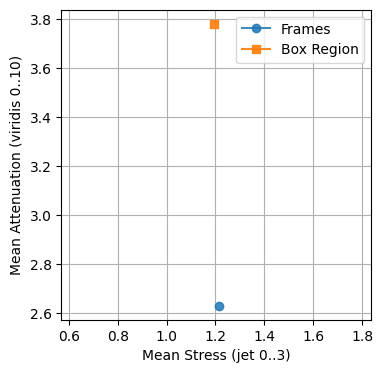

In [12]:
class MainApp(tk.Tk):
    def __init__(self):
        super().__init__()
        self.title("OCT Deformation Tracking Suite")
        self.geometry("1200x800")
        style = ttk.Style(self)
        style.theme_use('clam')
        style.configure('TNotebook.Tab', padding=(10, 10))

        notebook = ttk.Notebook(self)
        notebook.pack(fill='both', expand=True)

        # add all your existing pages + the new one
        pages = [
            (HomePage,                "Home"),
            (PreprocessingPage,       "Preprocessing"),
            (OpticalFlowPage,         "Optical Flow"),
            (ImageSynthesisPage,      "Image Synthesis"),
            (BenchmarkingPage,        "Benchmarking"),
            (FieldWarpingPage,        "Field Warping"),
            (MultiModalFieldWarpPage,   "Attenuation Registration"),
            (StressAttenuationExplorer, "Relationship Explorer")
        ]

        for PageClass, title in pages:
            page = PageClass(notebook)
            notebook.add(page, text=title)

if __name__ == "__main__":
    MainApp().mainloop()